In [33]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist, squareform


#### Get audio vector and inital tempo estimation

In [75]:
path = '../audio/aphex_twin_ageispolis.mp3'
loader = estd.AudioLoader(filename=path)
downmixer = estd.MonoMixer()
tempAudioInput, fs, numb_channels, md5, bit_rate, codec = loader()
audioInput = downmixer(tempAudioInput, numb_channels)
tempo_estimation_algo = estd.PercivalBpmEstimator(sampleRate=int(fs))
bpm = tempo_estimation_algo(audioInput)
print(bpm)

101.83189392089844


#### Compute spectrogram and 2-band energy

In [76]:
# Dynamic Programming Python implementation of Min Cost Path
R = 30
C = 30
def minCost(cost, m, n): 
  
    # Instead of following line, we can use int tc[m+1][n+1] or 
    # dynamically allocate memoery to save space. The following 
    # line is used to keep te program simple and make it working 
    # on all compilers.
    tc = [[0 for x in range(C)] for x in range(R)] 
  
    tc[0][0] = cost[0][0] 
  
    # Initialize first column of total cost(tc) array 
    for i in range(1, m+1): 
        tc[i][0] = tc[i-1][0] + cost[i][0] 
  
    # Initialize first row of tc array 
    for j in range(1, n+1): 
        tc[0][j] = tc[0][j-1] + cost[0][j] 
  
    # Construct rest of the tc array 
    for i in range(1, m+1): 
        for j in range(1, n+1): 
            tc[i][j] = min(tc[i-1][j-1], tc[i-1][j], tc[i][j-1]) + cost[i][j] 
  
    return tc[m][n] 

In [77]:
## var init
frame_size = 1024
hop_size = 512
fft_size = 1024

## get necessary Essentia algorithms
window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann')
fft_algo = estd.FFT(size = fft_size)

spectrogram = []
db_spectrogram = []
print('Frame Size:', frame_size)
print('FFT Size:', fft_size)

for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
    ## spectrogram
    windowed_frame = window_algo(frame)
    mX = abs(fft_algo(windowed_frame))
    mX[mX<np.finfo(float).eps] = np.finfo(float).eps    ## if zeros add epsilon to handle log
    dbX = 20 * np.log10(mX)
    spectrogram.append(np.array(mX))
    db_spectrogram.append(np.array(dbX))
    
spectrogram = np.array(spectrogram)
db_spectrogram = np.array(db_spectrogram)
print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)

Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (27852, 513)


#### Plot Spectrogram (for visual feedback only)

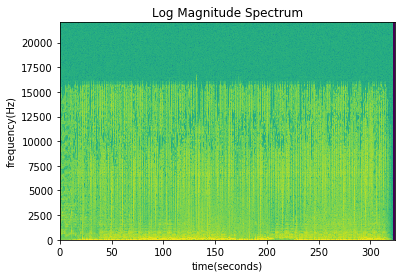

In [78]:
timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

In [79]:
# beat estimation
beatTracker = estd.BeatTrackerDegara()
beats = beatTracker(audioInput)
beats_frames = [int(bf) for bf in (beats * fs / hop_size)]
#print(beats)
print(len(beats))
#print(beats_frames)

547


In [80]:
# for i in range(len(beats)-1):
#     dur_beats.append(beats[i+1] - beats[i])
#     pc8_dur_beats.append(dur_beats[i] * 0.08)

# avDur = np.average(dur_beats)
# avDurInFrames = int(avDur * fs / hop_size)
# avDur8 = np.average(pc8_dur_beats)
# avDur8InFrames = int(avDur8 * fs / hop_size)
# print(avDurInFrames)
# print(avDur8InFrames)

# framePosBeat = []
beats_neighbour_spect = {}
i = 0

while i <= len(beats_frames)-1:
    if i != len(beats_frames)-1:
        beat_duration = beats_frames[i+1] - beats_frames[i]
    duration_8_percent = int(beat_duration*0.08)
    beats_neighbour_spect[beats_frames[i]] = spectrogram[beats_frames[i]-duration_8_percent:beats_frames[i]+duration_8_percent]
    i += 1

ASM_dict = {}
for beat_x in beats_neighbour_spect:
    ASM_dict[beat_x] = {}
    for beat_y in beats_neighbour_spect:
        temp_ASM = cdist(beats_neighbour_spect[beat_x], beats_neighbour_spect[beat_y], metric='euclidean')
        ASM_dict[beat_x][beat_y] = temp_ASM

In [81]:
print(len(beats_frames))

547


In [97]:
BSM = []
counti = 0 
for beat_frame_i, ASM_beat_dict in ASM_dict.items():
    BSM.append([])
    for beat_frame_j, ASM in ASM_beat_dict.items():
        BSM[counti].append(minCost(ASM, ASM.shape[0]-1, ASM.shape[1]-1))
    counti += 1

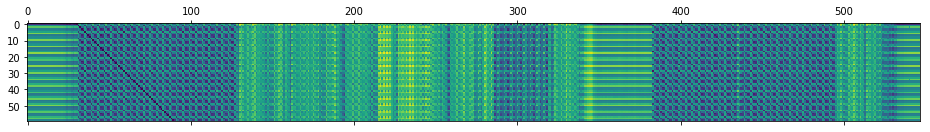

In [98]:
plt.matshow(BSM[30:90])
plt.savefig("f.pdf")